In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

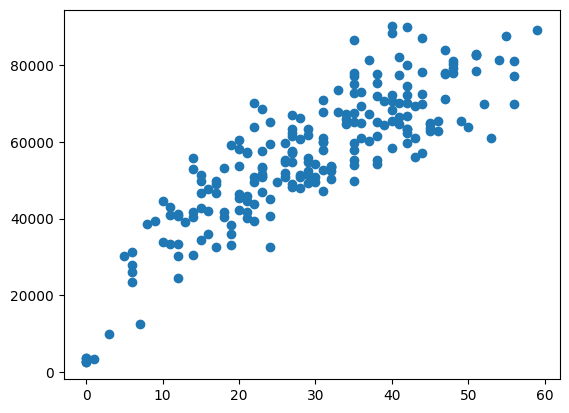

In [5]:
silver = pd.read_csv("silver_data")

plt.scatter(silver['totalKills'], silver['totalGold'])

plt.show()